# Time series differentiation

## Introduction

Time series differentiation involves computing the differences between consecutive observations in the time series. When it comes to training forecasting models, differentiation offers the advantage of focusing on relative rates of change rather than directly attempting to model the absolute values. Once the predictions have been estimated, this transformation can be easily reversed to restore the values to their original scale.

This methodology is very useful when dealing with time series that exhibit trends, as not all models can capture such trends properly. Among the many machine learning techniques, tree-based models, including decision trees, random forests, and gradient boosting machines (GBMs), stand out for their effectiveness and broad applicability to various domains. Nonetheless, these models are limited in their ability to extrapolate. Their inability to project values outside the observed range during training inevitably results in predicted values that deviate from the underlying trend.

Skforecast, version 0.10.0 or higher, introduces a novel `differentiation` parameter within its forecasters. This parameter indicates that a differentiation process must be applied before training the model, and this task is performed through the internal use of a new class named `skforecast.preprocessing.TimeSeriesDifferentiator`. It is important to note that the entire differentiation process is automated and its effects are seamlessly reversed during the prediction phase. This ensures that the resulting forecast values are in the original scale of the time series data.

## TimeSeriesDifferentiator

[TimeSeriesDifferentiator](https://skforecast.org/latest/api/preprocessing) is a custom transformer that follows the preprocessing sklearn API. This means it has the method `fit`, `transform`, `fit_transform` and `inverse_transform`.

In [100]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.preprocessing import TimeSeriesDifferentiator

In [101]:
# Differentiation with TimeSeriesDifferentiator
# ==============================================================================
y = np.array([5, 8, 12, 10, 14, 17, 21, 19], dtype=float)
diffenciator = TimeSeriesDifferentiator()
diffenciator.fit(y)
y_diff = diffenciator.transform(y)

print(f"Original time series   : {y}")
print(f"Differenced time series: {y_diff}")

Original time series   : [ 5.  8. 12. 10. 14. 17. 21. 19.]
Differenced time series: [nan  3.  4. -2.  4.  3.  4. -2.]


The process of differencing can be reversed (integration) using the `inverse_transform` method.

In [102]:
diffenciator.inverse_transform(y_diff)

array([ 5.,  8., 12., 10., 14., 17., 21., 19.])

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

The inverse transformation process, <code>inverse_transform</code>, is applicable only to the same time series that was previously differentiated using the same <code>TimeSeriesDifferentiator</code> object. This limitation arises from the need to use the initial <i>n</i> values of the time series (<i>n</i> equals the order of differentiation) to successfully reverse the differentiation. These values are stored when the <code>fit</code> method is executed.

</div>

<br>

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px;">
<p class="title">
    <i class="fa-light fa-pencil fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>

An additional method <code>inverse_transform_next_window</code> is available in the <code>TimeSeriesDifferentiator</code>. This method is designed to be used inside the Forecasters to reverse the differentiation of the predicted values. If the Forecaster regressor is trained with a differentiated time series, then the predicted values will be differentiated as well. The <code>inverse_transform_next_window</code> method allows to return the predictions to the original scale, with the assumption that they start immediately after the last values observed (<code>last_window</code>).

</div>

## Forecasting with differentiation

In [103]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.preprocessing import TimeSeriesDifferentiator
from skforecast.model_selection import backtesting_forecaster

Train dates : 1949-01-01 00:00:00 --- 1956-12-01 00:00:00  (n=96)
Test dates  : 1957-01-01 00:00:00 --- 1960-12-01 00:00:00  (n=48)


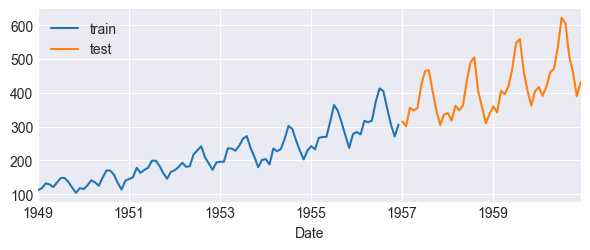

In [104]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/AirPassengers.csv'
)
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data = data.set_index('Date')
data = data.asfreq('MS')
data = data['Passengers']
data = data.sort_index()
data.head(4)

# Data partition train-test
# ==============================================================================
end_train = '1956-12-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

Two autoregressive forecasters are created, one with a scikit-learn `RandomForestRegressor` and the other with an `XGBoost`. Both are trained on data from 1949-01-01 to 1956-12-01 and produce forecasts for the next 48 months (4 years).

Error (MAE) Random Forest: 54.79
Error (MAE) Gradient Boosting: 48.46


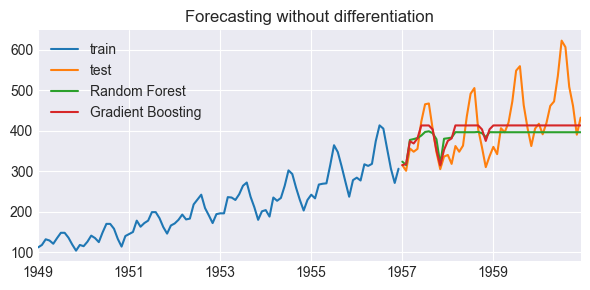

In [105]:
# Forecasting without differentiation
# ==============================================================================
steps = len(data.loc[end_train:])

# Forecasters
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 12
                )
forecaster_gb = ForecasterAutoreg(
                    regressor = XGBRegressor(random_state=963),
                    lags      = 12
                )
# Train
forecaster_rf.fit(data.loc[:end_train])
forecaster_gb.fit(data.loc[:end_train])

# Predict
predictions_rf = forecaster_rf.predict(steps=steps)
predictions_gb = forecaster_gb.predict(steps=steps)

# Error
error_rf = mean_absolute_error(data.loc[end_train:], predictions_rf)
error_gb = mean_absolute_error(data.loc[end_train:], predictions_gb)
print(f"Error (MAE) Random Forest: {error_rf:.2f}")
print(f"Error (MAE) Gradient Boosting: {error_gb:.2f}")

# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Random Forest')
predictions_gb.plot(ax=ax, label='Gradient Boosting')
ax.set_title(f'Forecasting without differentiation')
ax.set_xlabel('')
ax.legend();

The plot shows that none of the models is capable of accurately predicting the trend. After a few steps, the predictions become nearly constant, close to the maximum values observed in the training data.

Next, two new forecasters are trained using the same configuration, but with the argument `differentiation = 1`. This activates the internal process of differencing (order 1) the time series before training the model, and reverses the differentiation (also known as integration) for the predicted values.

Error (MAE) Random Forest: 24.91
Error (MAE) Gradient Boosting: 24.60


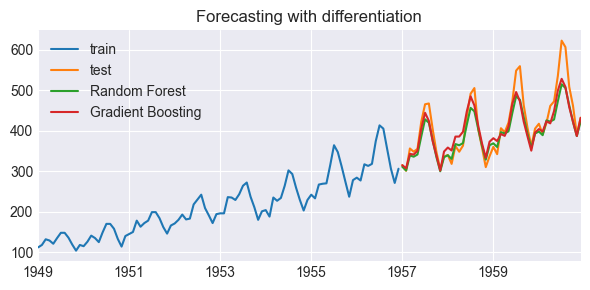

In [106]:
# Forecasting with differentiation
# ==============================================================================
steps = len(data.loc[end_train:])

# Forecasters
forecaster_rf = ForecasterAutoreg(
                    regressor       = RandomForestRegressor(random_state=963),
                    lags            = 12,
                    differentiation = 1
                )
forecaster_gb = ForecasterAutoreg(
                    regressor       = XGBRegressor(random_state=963),
                    lags            = 12,
                    differentiation = 1
                )
# Train
forecaster_rf.fit(data.loc[:end_train])
forecaster_gb.fit(data.loc[:end_train])

# Predict
predictions_rf = forecaster_rf.predict(steps=steps)
predictions_gb = forecaster_gb.predict(steps=steps)

# Error
error_rf = mean_absolute_error(data.loc[end_train:], predictions_rf)
error_gb = mean_absolute_error(data.loc[end_train:], predictions_gb)
print(f"Error (MAE) Random Forest: {error_rf:.2f}")
print(f"Error (MAE) Gradient Boosting: {error_gb:.2f}")

# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Random Forest')
predictions_gb.plot(ax=ax, label='Gradient Boosting')
ax.set_title(f'Forecasting with differentiation')
ax.set_xlabel('')
ax.legend();

This time, both models are able to follow the trend in their predictions.

## Internal differentiation vs pre-processing

Forecasters manage the differentiation process internally, so there is no need for additional pre-processing of the time series and post-processing of the predictions. This has several advantages, but before diving in, the results of both approaches are compared.

In [107]:
# Time series differentiated by preprocessing before training
# ==============================================================================
diferenciator = TimeSeriesDifferentiator(order=1)
data_diff = diferenciator.fit_transform(data)
data_diff = pd.Series(data_diff, index=data.index).dropna()

forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )
forecaster.fit(y=data_diff.loc[:end_train])
predictions_diff = forecaster.predict(steps=steps)

# Revert differentiation to obtain final predictions
last_value_train = data.loc[:end_train].iloc[[-1]]
predictions_1 = pd.concat([last_value_train, predictions_diff]).cumsum()[1:]
predictions_1 = predictions_1.asfreq('MS')
predictions_1.name = 'pred'
predictions_1.head(5)

1957-01-01    312.00
1957-02-01    302.93
1957-03-01    341.61
1957-04-01    338.03
1957-05-01    341.97
Freq: MS, Name: pred, dtype: float64

In [108]:
# Time series differentiated internally by the forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor       = RandomForestRegressor(random_state=963),
                 lags            = 15,
                 differentiation = 1
             )
forecaster.fit(y=data.loc[:end_train])
predictions_2 = forecaster.predict(steps=steps)
predictions_2.head(5)

1957-01-01    312.00
1957-02-01    302.93
1957-03-01    341.61
1957-04-01    338.03
1957-05-01    341.97
Freq: MS, Name: pred, dtype: float64

In [109]:
# Compare both predictions
# ==============================================================================
pd.testing.assert_series_equal(predictions_1, predictions_2)

Predictions are equivalent for both approaches.

The results are also equivalent when a transformation, such as standardization, is applied to the time series. In this case, the order of the steps is: transformation -> differentiation -> model fitting -> prediction -> inverse differentiation -> inverse transformation.

In [124]:
# Time series differentiated by preprocessing before training
# ==============================================================================
scaler = StandardScaler()
scaler.fit(data.loc[:end_train].to_numpy().reshape(-1, 1))
data_scaled = scaler.transform(data.to_numpy().reshape(-1, 1))
data_scaled = pd.Series(data_scaled.flatten(), index=data.index)
data_scaled_diff = TimeSeriesDifferentiator(order=1).fit_transform(data_scaled)
data_scaled_diff = pd.Series(data_scaled_diff, index=data.index).dropna()

forecaster = ForecasterAutoreg(
                 regressor     = RandomForestRegressor(random_state=963),
                 lags          = 15,
             )
forecaster.fit(y=data_scaled_diff.loc[:end_train])
predictions_diff = forecaster.predict(steps=steps)

# Revert differentiation to obtain final predictions
last_value_train = data_scaled.loc[:end_train].iloc[[-1]]
predictions_1 = pd.concat([last_value_train, predictions_diff]).cumsum()[1:]
# Revert the scaling
predictions_1 = scaler.inverse_transform(predictions_1.to_numpy().reshape(-1, 1))
predictions_1 = pd.Series(predictions_1.flatten(), index=data.loc[end_train:].index.to_numpy())
predictions_1 = predictions_1.asfreq('MS')
predictions_1.name = 'pred'
display(predictions_1.head(5))

# Time series differentiated internally by the forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor       = RandomForestRegressor(random_state=963),
                 lags            = 15,
                 differentiation = 1,
                 transformer_y = StandardScaler()
             )
forecaster.fit(y=data.loc[:end_train])
predictions_2 = forecaster.predict(steps=steps)
display(predictions_2.head(5))

# Compare both predictions
# ==============================================================================
pd.testing.assert_series_equal(predictions_1, predictions_2)

1957-01-01    312.43
1957-02-01    303.45
1957-03-01    342.44
1957-04-01    340.00
1957-05-01    343.82
Freq: MS, Name: pred, dtype: float64

1957-01-01    312.43
1957-02-01    303.45
1957-03-01    342.44
1957-04-01    340.00
1957-05-01    343.82
Freq: MS, Name: pred, dtype: float64

Next, the outcomes of the [backtesting process](https://skforecast.org/latest/user_guides/backtesting) are subjected to a comparative analysis. This comparison is more complex than the previous one, as the process of undoing the differentiation must be performed separately for each backtesting fold.

In [11]:
# Backtesting with the time series differentiated by preprocessing before training
# ==============================================================================
steps = 5
forecaster_1 = ForecasterAutoreg(
                   regressor = RandomForestRegressor(random_state=963),
                   lags      = 15
               )

_, predictions_1 = backtesting_forecaster(
                       forecaster            = forecaster_1,
                       y                     = data_diff,
                       steps                 = steps,
                       metric                = 'mean_squared_error',
                       initial_train_size    = len(data_diff.loc[:end_train]),
                       fixed_train_size      = False,
                       gap                   = 0,
                       allow_incomplete_fold = True,
                       refit                 = True,
                       n_jobs                = 'auto',
                       verbose               = False,
                       show_progress         = True  
                   )

# Revert differentiation of predictions. Predictions of each fold must be reverted
# individually. An id is added to each prediction to identify the fold to which it belongs.
predictions_1 = predictions_1.rename(columns={'pred': 'pred_diff'})
folds = len(predictions_1) / steps
folds = int(np.ceil(folds))
predictions_1['backtesting_fold_id'] = np.repeat(range(folds), steps)[:len(predictions_1)]

# Add the previously observed value of the time series (only to the first prediction of each fold)
previous_overved_values = data.shift(1).loc[predictions_1.index].iloc[::steps]
previous_overved_values.name = 'previous_overved_value'
predictions_1 = predictions_1.merge(
                    previous_overved_values,
                    left_index  = True,
                    right_index = True,
                    how         = 'left'
                )
predictions_1 = predictions_1.fillna(0)
predictions_1['summed_value'] = (
    predictions_1['pred_diff'] + predictions_1['previous_overved_value']
)

# Revert differentiation using the cumulative sum by fold
predictions_1['pred'] = (
    predictions_1
    .groupby('backtesting_fold_id')
    .apply(lambda x: x['summed_value'].cumsum())
    .to_numpy()
)

predictions_1.head(5)

  0%|          | 0/12 [00:00<?, ?it/s]

,pred_diff,backtesting_fold_id,previous_overved_value,summed_value,pred
1956-02-01,-9.60,0,284.0,274.40,274.40
1956-03-01,31.80,0,0.0,31.80,306.20
1956-04-01,2.74,0,0.0,2.74,308.94
1956-05-01,-0.34,0,0.0,-0.34,308.60
1956-06-01,38.09,0,0.0,38.09,346.69


In [12]:
# Backtesting with the time series differentiated internally
# ==============================================================================
forecaster_2 = ForecasterAutoreg(
                   regressor       = RandomForestRegressor(random_state=963),
                   lags            = 15,
                   differentiation = 1
               )

_, predictions_2 = backtesting_forecaster(
                       forecaster            = forecaster_2,
                       y                     = data,
                       steps                 = steps,
                       metric                = 'mean_squared_error',
                       initial_train_size    = len(data.loc[:end_train]),
                       fixed_train_size      = False,
                       gap                   = 0,
                       allow_incomplete_fold = True,
                       refit                 = True,
                       n_jobs                = 'auto',
                       verbose               = False,
                       show_progress         = True  
                   )

predictions_2.head(5)

  0%|          | 0/12 [00:00<?, ?it/s]

,pred
1956-02-01,274.40
1956-03-01,306.20
1956-04-01,308.94
1956-05-01,308.60
1956-06-01,346.69


In [13]:
# Compare both predictions
# ==============================================================================
pd.testing.assert_series_equal(predictions_1['pred'], predictions_2['pred'])

Finally, the validation is also performed for the predictions obtained with `predict_boostrapping`.

In [125]:
# Time series differentiated by preprocessing before training
# ==============================================================================
forecaster_1 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )

forecaster_1.fit(y=data_diff.loc[:end_train])
boot_predictions_diff = forecaster_1.predict_bootstrapping(
                            steps  = steps,
                            n_boot = 10
                        )
# Revert differentiation of predictions
last_value_train = data.loc[:end_train].iloc[[-1]]
boot_predictions_1 = boot_predictions_diff.copy()
boot_predictions_1.loc[last_value_train.index[0]] = last_value_train.values[0]
boot_predictions_1 = boot_predictions_1.sort_index()
boot_predictions_1 = boot_predictions_1.cumsum(axis=0).iloc[1:,]
boot_predictions_1 = boot_predictions_1.asfreq('MS')

# Time series differentiated internally by the forecaster
# ==============================================================================
forecaster_2 = ForecasterAutoreg(
                 regressor       = RandomForestRegressor(random_state=963),
                 lags            = 15,
                 differentiation = 1
               )

forecaster_2.fit(y=data.loc[:end_train])
boot_predictions_2 = forecaster_2.predict_bootstrapping(steps=steps, n_boot=10)

pd.testing.assert_frame_equal(boot_predictions_1, boot_predictions_2)

## Conslusions

If, as demonstrated, the values are equivalent when differentiating the time series in a preprocessing step or when allowing the Forecaster to manage the differentiation internally, why the second alternative is better?

+ Allowing the forecaster to manage all transformations internally guarantees that the same transformations are applied when the model is run on new data.

+ When the model is applied to new data that does not follow immediately after the training data (for example, if a model is not retrained for each prediction phase), the forecaster automatically increases the size of the last window needed to generate the predictors, as well as applying the differentiation to the incoming data and undoing it in the final predictions.

These transformations are non-trivial and very error-prone, so **skforecast** tries to avoid overcomplicating the already challenging task of forecasting time series.

In [ ]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>